# Ligand receptor specfic enrichment analysis.

This notebook demonstrates ligand-specific enrichment analysis. Similar to the differential gene analysis, We can observe that the ligand receptor pair specifically enriched in a certain spatial region. This is done in the following three steps.

1. Construct a new anndata object, in which the columns of the matrix are cell-cell pairs, while the rows ligand-receptor mechanisms.
2. Based on above matrix, do dimensionality reduction,spatial clustering and differential mechanisms (ligand-receptor) analysis, to find the specifically enriched in a certain spatial region.

 **Reference**: Micha Sam Brickman Raredon, Junchen Yang, Neeharika Kothapalli,  Naftali Kaminski, Laura E. Niklason,Yuval Kluger. Comprehensive visualization of cell-cell interactions in single-cell and spatial transcriptomics with NICHES. doi: https://doi.org/10.1101/2022.01.23.477401

In [ ]:
import os
import spateo as st
import dynamo as dyn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Load data

We will be using a axolotl dataset from [Wei et al., 2022] (https://doi.org/10.1126/science.abp9444).

Here, we can get data directly from the function`st.sample.axolotl` or link: 

axolotl_2DPI: https://www.dropbox.com/s/6ihasky6mey286l/axolotl_2DPI.h5ad?dl=1

In [ ]:
adata = st.sample_data.axolotl(filename='axolotl_2DPI.h5ad')
adata

AnnData object with n_obs × n_vars = 7668 × 27324
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'inj_M_L', 'Annotation'
    var: 'Axolotl_ID', 'hs_gene'
    uns: 'Annotation_colors', 'Injury_2DPI_rep1_SS200000147BL_D5', '__type', 'angle_dict', 'color_key', 'neighbors', 'pp', 'umap_fit'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'pearson_residuals', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [3]:
adata.var['new_name'] = adata.var.index
adata.var.index = adata.var['Axolotl_ID']

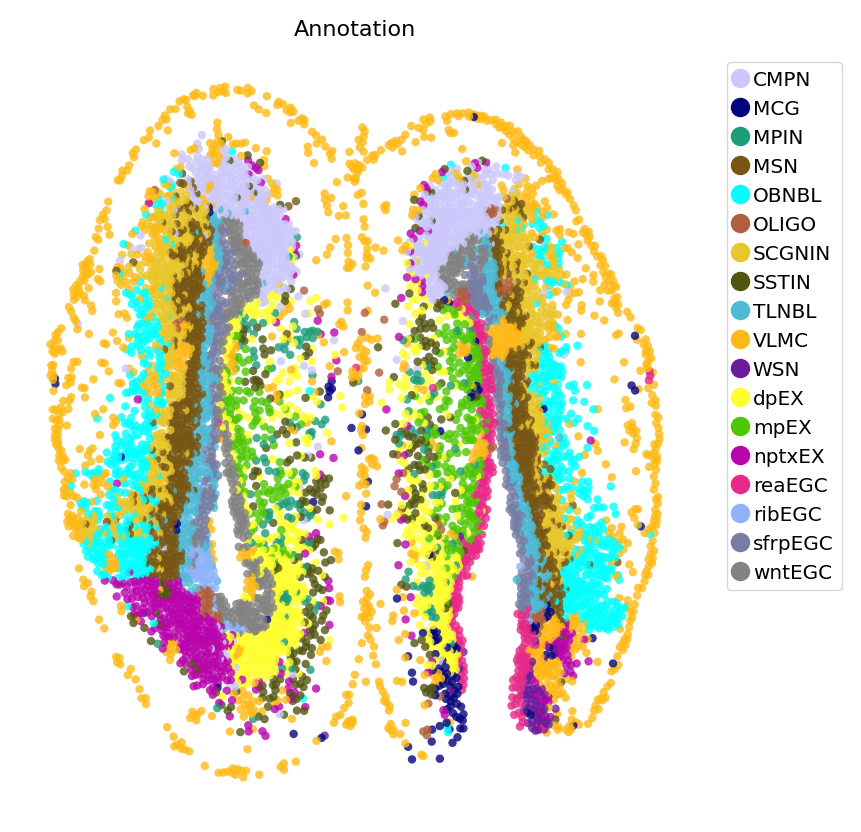

In [4]:
st.pl.space(adata,
            color=['Annotation'],
            pointsize=0.2,
            color_key=adata.uns['color_key'],
            show_legend='upper left',
            figsize=(5, 5))

## Construct new adata.

First, calculate spatial nearest neighbor graph, limiting the nearest neighbor per cell to `k`. This function returns another anndata object, in which the columns of the matrix are cell-cell pairs, while the rows ligand-receptor mechanisms.

In [5]:
weights_graph, distance_graph, adata = st.tl.weighted_spatial_graph(
    adata,
    n_neighbors=10,
)

|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.
|-----> <insert> spatial_weights to obsp in AnnData Object.


In [6]:
adata_n2n = st.tl.niches(adata,
                         path='/DATA/User/zuolulu/spateo-release/spateo/tools/database/',
                         layer=None,
                         species='axolotl',
                         system='niches_n2n',
                         method='sum')
adata_n2n

AnnData object with n_obs × n_vars = 7668 × 916
    obs: 'cell_pair_name'

Copy some of the other attributes from `adata` to `adata_n2n`. 
(Note assignment based on actual data).

In [10]:
adata_n2n.uns['__type'] = 'UMI'
adata_n2n.obsm['spatial'] = adata.obsm['spatial']

## Downstream analysis.

Then, we can do dimensionality reduction , spatial clustering and differential mechanisms (ligand-receptor) analysis based on this new object. Therefore, we can find the ligand-receptor pairs which are specially enriched in a certain region. 

`preprocessing`

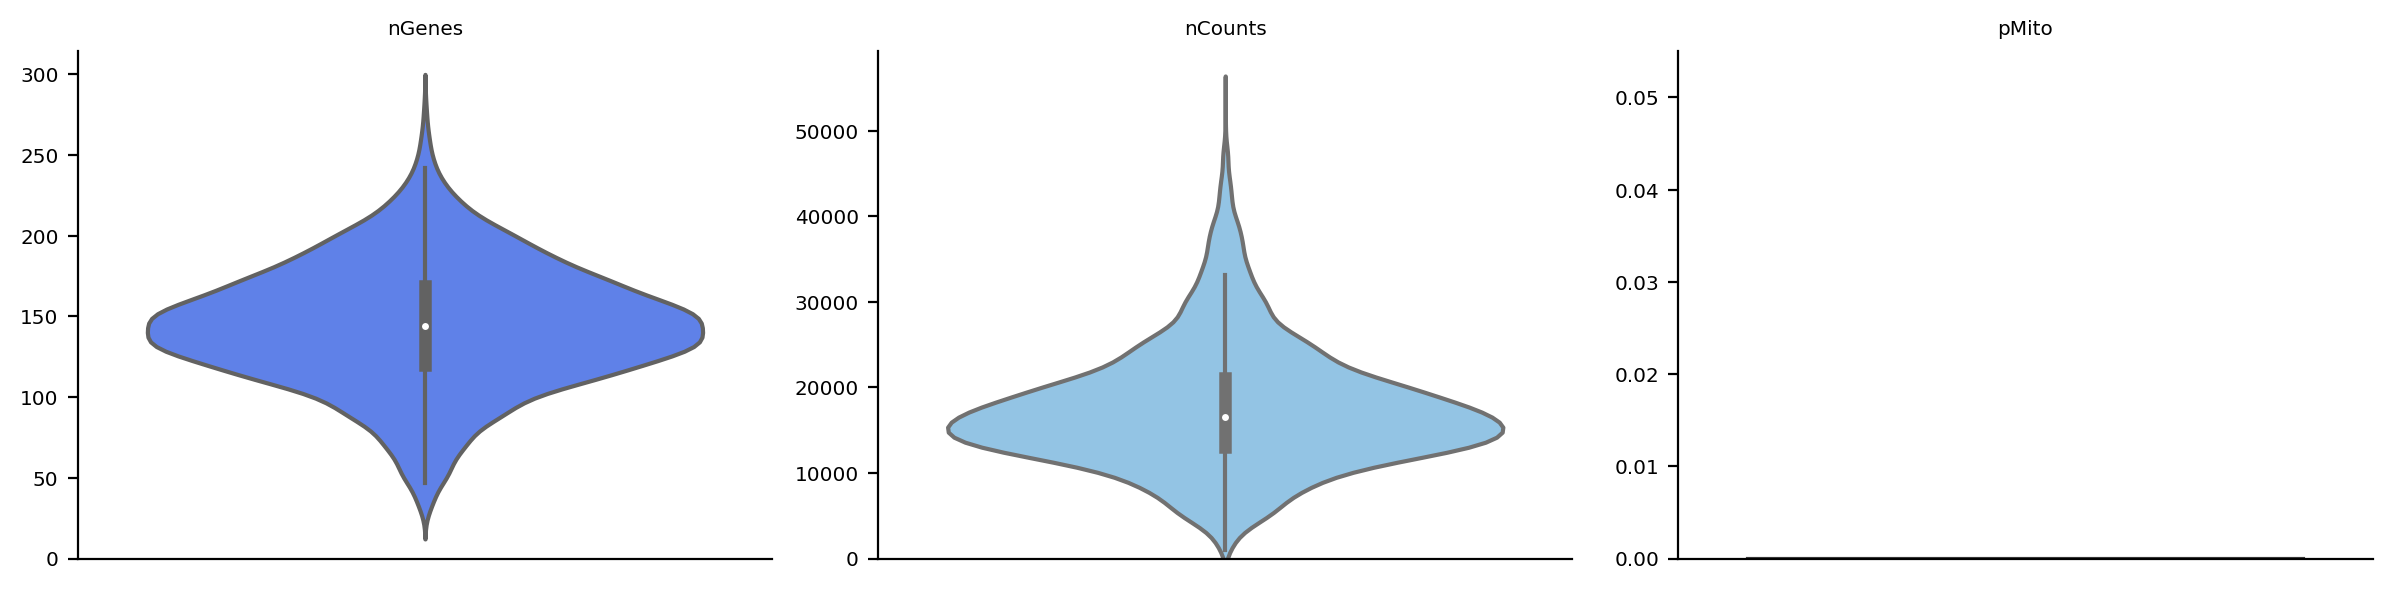

|-----> rounding expression data of layer: X during size factor calculation
|-----> size factor normalize following layers: ['X']
|-----> applying <ufunc 'log1p'> to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.


AnnData object with n_obs × n_vars = 7668 × 916
    obs: 'cell_pair_name', 'n_counts', 'nGenes', 'nCounts', 'pMito', 'Size_Factor', 'initial_cell_size'
    var: 'nCells', 'nCounts'
    uns: '__type', 'pp'
    obsm: 'spatial', 'pearson_residuals'
    layers: 'raw', 'norm_log1p'

In [11]:
adata_n2n.obs['n_counts'] = adata_n2n.X.sum(axis=1).A1
adata_n2n.uns["pp"] = {}
adata_n2n.var_names_make_unique()
dyn.pl.basic_stats(adata_n2n)
adata_n2n.layers['raw'] = adata_n2n.X
dyn.pp.normalize_cell_expr_by_size_factors(adata_n2n, layers="X")
adata_n2n.layers['norm_log1p'] = adata_n2n.X.copy()
adata_n2n.X = adata_n2n.layers['raw'].copy()
st.tl.pearson_residuals(adata_n2n, n_top_genes=None)
adata_n2n

In [12]:
bad_genes = np.isnan(adata_n2n.obsm["pearson_residuals"].sum(0))
bad_genes.sum()
st.tl.pca_spateo(adata=adata_n2n, X_data=adata_n2n.obsm["pearson_residuals"]
                 [:, ~bad_genes], n_pca_components=30, pca_key="X_pca", random_state=1)
dyn.tl.neighbors(adata_n2n, n_neighbors=30)

|-----> Runing PCA on user provided data...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 7668 × 916
    obs: 'cell_pair_name', 'n_counts', 'nGenes', 'nCounts', 'pMito', 'Size_Factor', 'initial_cell_size'
    var: 'nCells', 'nCounts'
    uns: '__type', 'pp', 'neighbors'
    obsm: 'spatial', 'pearson_residuals', 'X_pca'
    layers: 'raw', 'norm_log1p'
    obsp: 'distances', 'connectivities'

`clustering`

|-----> accessing adj_matrix_key=distances built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to networkx object
|-----> [Community clustering with louvain] in progress: 100.0000%
|-----> [Community clustering with louvain] finished [412.6376s]


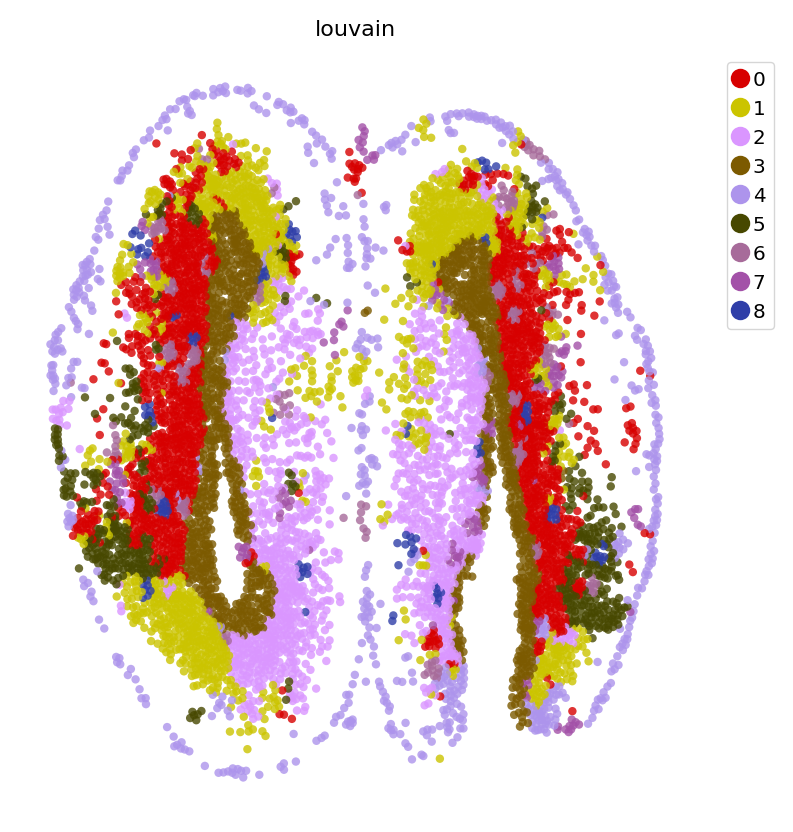

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [43.6265s]


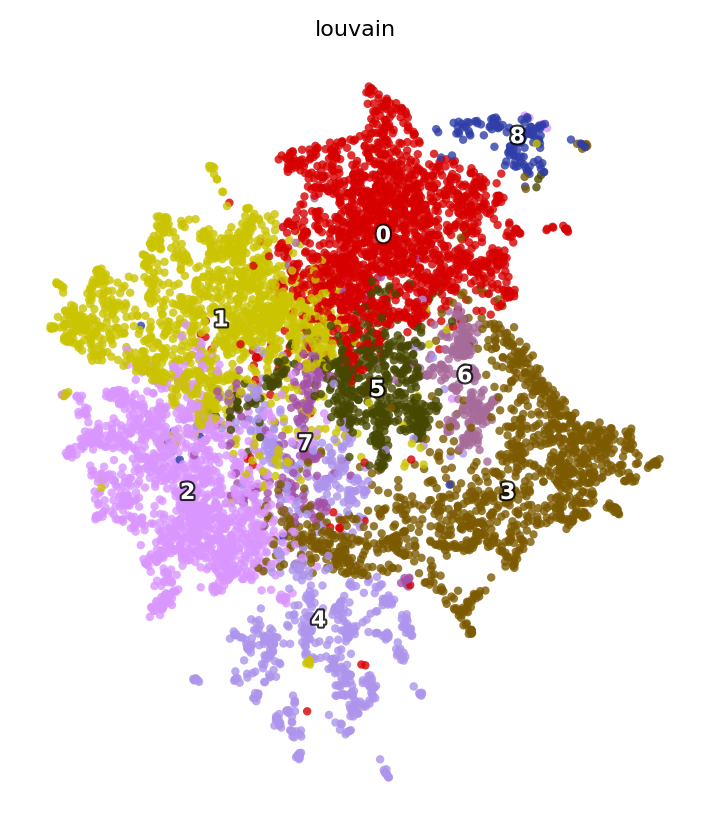

In [13]:
dyn.tl.louvain(adata_n2n, resolution=2)
st.pl.space(adata_n2n,
            color=['louvain'],
            pointsize=0.2,
            figsize=(5, 5),
            show_legend="upper left")
dyn.tl.reduceDimension(adata_n2n)
st.pl.space(adata_n2n,
            color=['louvain'],
            figsize=(5, 5),
            space="umap",
            pointsize=0.2)

`differential analysis`

In [42]:
# (optional: just Suitable for axolotl, homologous gene to human)
#adata_n2n.var['lr_pair_name'] = adata_n2n.var.index
df = adata_n2n.var['lr_pair_name'].str.split('-', expand=True)
df.columns = ['ligand', 'receptor']
##
df1 = adata.var
df1.index.name = None
df2 = pd.merge(df, df1, left_on='ligand', right_on='Axolotl_ID').drop(
    ['Axolotl_ID', 'new_name'], axis=1)
df2.columns = ['ligand', 'receptor', 'ligand_human']
df3 = pd.merge(df2, df1, left_on='receptor',
               right_on='Axolotl_ID').drop(['Axolotl_ID', 'new_name'], axis=1)
df3.columns = ['ligand', 'receptor', 'ligand_human', 'receptor_human']
df3['ligand_human'] = df3['ligand_human'].astype('str')
df3['receptor_human'] = df3['receptor_human'].astype('str')
df3['lr_pair'] = df3["ligand_human"] + "-" + df3["receptor_human"]
adata_n2n.var['lr_pair'] = df3['lr_pair'].tolist()
adata_n2n.var.index = adata_n2n.var['lr_pair']

In [33]:
adata_n2c_marker = st.tl.find_all_cluster_degs(
    adata_n2n, group='louvain', genes=None, n_jobs=1)

identifying top markers for each group: 916it [00:04, 223.56it/s]
identifying top markers for each group: 916it [00:04, 214.35it/s]
identifying top markers for each group: 916it [00:04, 199.74it/s]
identifying top markers for each group: 916it [00:05, 178.17it/s]
identifying top markers for each group: 916it [00:04, 224.85it/s]
identifying top markers for each group: 916it [00:03, 236.41it/s]
identifying top markers for each group: 916it [00:04, 217.55it/s]
identifying top markers for each group: 916it [00:04, 201.59it/s]
identifying top markers for each group: 916it [00:04, 204.19it/s]


In [34]:
# top_n_markers
marker_genes_dict = st.tl.top_n_degs(
    adata_n2c_marker, group='louvain', top_n_genes=3)

In [35]:
deg_table = st.tl.top_n_degs(adata_n2c_marker, group='louvain',
                             only_deg_list=False, sort_by='cosine_score', top_n_genes=3)

In [36]:
markers = deg_table['gene'].unique().tolist()
adata_n2n.var_names_make_unique()
adata_n2n.obs['louvain'] = adata_n2n.obs['louvain'].astype('category')

(<Figure size 1000x300 with 4 Axes>,
 {'mainplot_ax': <AxesSubplot:>,
  'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
  'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>})

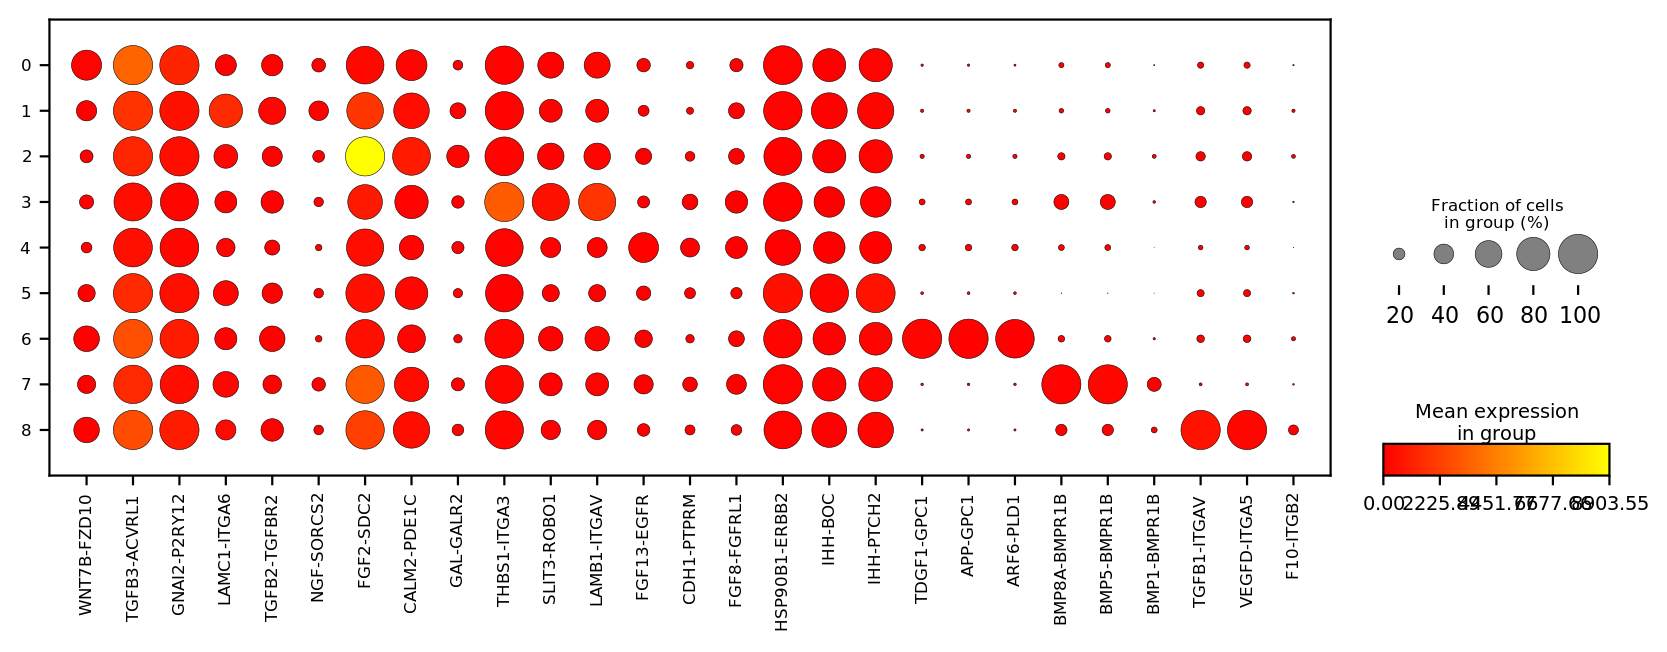

In [37]:
st.pl.dotplot(adata_n2n,
              var_names=markers,
              cat_key='louvain',
              cmap='autumn',
              figsize=(10, 3),
              save_show_or_return='return')

`Plot spatial in situ expression map`

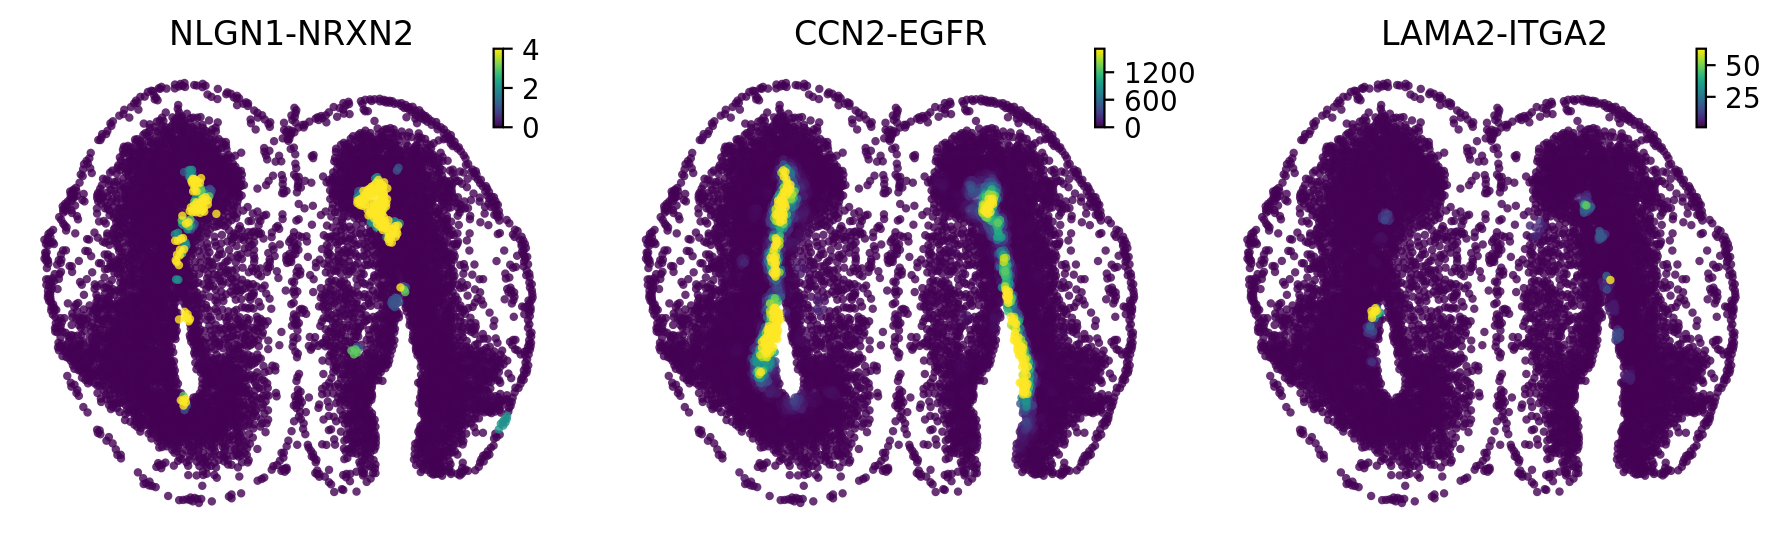

In [41]:
st.pl.space(adata_n2n,
            color=marker_genes_dict['3'],
            pointsize=0.2,
            ncols=3,
            figsize=(4, 3),
            show_legend="upper left")